# Stage 1.1

---

### _Content_:

1. Data Generation
2. Preprocessing the dataset
3. Pre-Training Setup
4. Training
5. Evaluation & Visualization
 
### _Requirements_:

1. numpy
2. matplotlib
3. scikit-learn

---

In [17]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Generation

In [18]:
# Set a global seed for reproducibility (To get the same random initializations)
np.random.seed(36)

In [19]:
# Assign the constants
N_SAMPLES = 100
N_INPUT_FEATURES = 2
N_OUTPUT_FEATURES = 1

In [20]:
w1_random = np.random.rand() * 100 - 50  # range = [-50, 50)
w2_random = np.random.rand() * 100 - 50  # range = [-50, 50)
w_random = np.array([w1_random, w2_random])
b_random = np.random.rand() * 100 - 50  # range = [-50, 50)

X = np.random.normal(loc=0, scale=1, size=(N_SAMPLES, N_INPUT_FEATURES))
y = (X @ w_random )+ b_random + np.random.normal(loc=0, scale=0.1, size=(N_SAMPLES))  # Adding a noise
y = y.reshape((-1, 1)) # Add extra dimention for consistent broadcasting (100,) -> (100,1)

In [21]:
X.shape, y.shape

((100, 2), (100, 1))

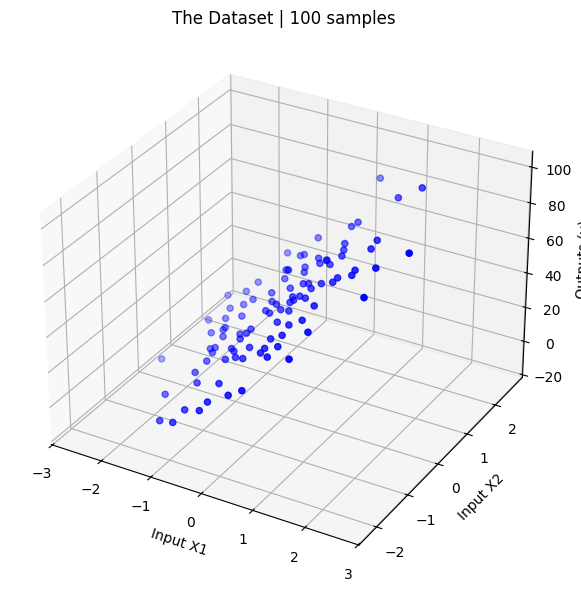

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y[:, 0], c='blue', marker='o')
ax.set_xlabel('Input X1')
ax.set_ylabel('Input X2')
ax.set_zlabel('Outputs (y)')
ax.set_title(f"The Dataset | {N_SAMPLES} samples")

plt.tight_layout()
plt.show()


## 2. Preprocessing the dataset

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 3. Pre-Training Setup

Using MSE (Mean Squared Error as a loss function)

In [25]:
def compute_loss(y_pred, y_real):
    if y_pred.shape != y_real.shape:
        raise ValueError(f"Shapes must be equal, got {y_pred.shape} and {y_real.shape}")
    errors = y_pred - y_real
    return np.mean(errors**2)

In [26]:
def compute_gradients(y_pred, y_real, X):
    errors = y_pred - y_real
    dL_dy_pred = 2/len(X) * errors
    w_gradient = dL_dy_pred.T @ X
    b_gradient = np.sum(dL_dy_pred)
    return {"w": w_gradient, "b": b_gradient}

In [27]:
class Optimizer:
    """
    An Adam Optimizer
    """

    def __init__(self, w, b, learning_rate=0.0001, beta_1=0.99):
        self.w = np.asarray(w)
        self.b = np.asarray(b)
        self.lr = learning_rate

        self.beta_1 = beta_1
        self.w_momentum = 0
        self.b_momentum = 0
        self.previous_w_momentum = 0
        self.previous_b_momentum = 0

    def step(self, epoch, w_gradient, b_gradient):
        self.previous_w_momentum = self.w_momentum
        self.previous_b_momentum = self.b_momentum
        
        self.w_momentum = (self.beta_1 * self.previous_w_momentum) + (w_gradient * self.lr)
        self.b_momentum = (self.beta_1 * self.previous_b_momentum) + (b_gradient * self.lr)

        self.w -= self.w_momentum
        self.b -= self.b_momentum

    def get_params(self):
        return {"w": self.w, "b": self.b}

In [28]:
history = {"epoch": [], "loss": [], "w": [], "b": []}

## 4. Training

In [29]:
MAX_EPOCHS: int = 500
MIN_LOSS: float = 0.9
LEARNING_RATE: float = 0.0001

In [30]:
epoch: int = 0
w = np.random.random(size=(N_OUTPUT_FEATURES, N_INPUT_FEATURES))
b: float = np.random.random(size=(N_OUTPUT_FEATURES, 1)) + 0.1

my_optimizer = Optimizer(w=w, b=b, learning_rate=LEARNING_RATE)

while True:
    # Get parameters from Optimizer
    params = my_optimizer.get_params()
    w = params["w"]
    b = params["b"]

    # Forward pass
    y_pred = X_train @ w.T + b
    loss = compute_loss(y_pred=y_pred, y_real=y_train)

    if loss <= MIN_LOSS or epoch >= MAX_EPOCHS:
        break

    # Backward pass
    gradients = compute_gradients(y_pred=y_pred, y_real=y_train, X=X_train)
    w_gradient = gradients["w"]
    b_gradient = gradients["b"]
    
    # # Optimization
    my_optimizer.step(epoch=epoch, w_gradient=w_gradient, b_gradient=b_gradient)
    epoch += 1

    history["epoch"].append(epoch)
    history["loss"].append(loss)
    history["w"].append(w)
    history["b"].append(b)
print(f"Training Finished:\t Epoch: {epoch} | Loss: {loss}")

Training Finished:	 Epoch: 500 | Loss: 13.637585130651729


## 5. Evaluation & Visualization

### Training

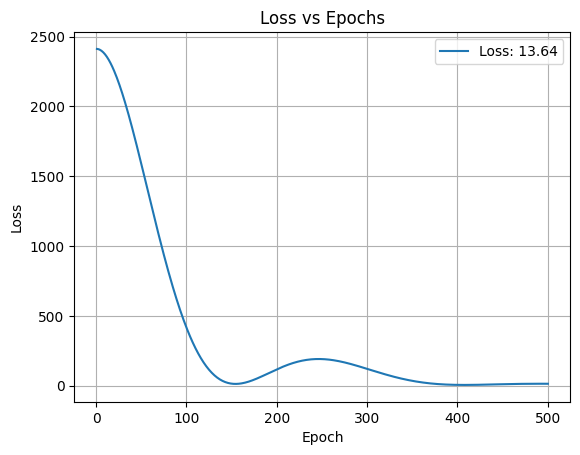

In [31]:
plt.plot(history['epoch'], history['loss'], label=f'Loss: {loss:.2f}')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Testing

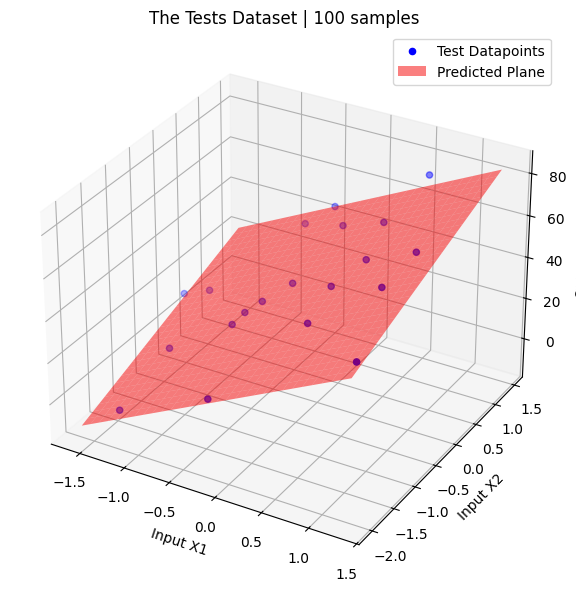

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test[:, 0], c='blue', marker='o', label="Test Datapoints")
ax.set_xlabel('Input X1')
ax.set_ylabel('Input X2')
ax.set_zlabel('Outputs (y)')
ax.set_title(f"The Tests Dataset | {N_SAMPLES} samples")

# Define a grid of x1 and x2 values
x1_range = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 30)
x2_range = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 30)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Calculate corresponding y values from the plane equation
y_pred_plane = w[0][0] * x1_grid + w[0][1] * x2_grid + b

ax.plot_surface(x1_grid, x2_grid, y_pred_plane, alpha=0.5, color='red', label= "Predicted Plane")

plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# # 1. w vs Epoch
# # 2. b vs Epoch

# ax[0].plot(history["epoch"], history["w"], label="w", color="blue")
# ax[0].axhline(y=w_random, color="r", linestyle="--", label="Target w")
# ax[0].set_title("w vs Epoch")
# ax[0].set_xlabel("Epoch")
# ax[0].set_ylabel("w")
# ax[0].legend()
# ax[0].grid(True)

# ax[1].plot(history["epoch"], history["b"], label="b", color="orange")
# ax[1].axhline(y=b_random, color="r", linestyle="--", label="Target b")
# ax[1].set_title("b vs Epoch")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("b")
# ax[1].legend()
# ax[1].grid(True)


# plt.suptitle("Parameters vs Epochs", fontsize=16)
# plt.tight_layout()
# plt.show()